In [61]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [86]:
from utils.data import get_data

class toy_args:

    def __init__(self, IC,tmin,tmax,n_trunk,n_branch):
        self.IC = IC
        self.tmin = tmin
        self.tmax = tmax
        self.xmin = -25
        self.xmax = 25
        self.Lx = self.xmax - self.xmin
        self.Lt = self.tmax - self.tmin
        self.Nt = 399
        self.Nx = 199
        self.n_trunk = n_trunk
        self.n_branch = n_branch
        self.load_data = False
        self.method = 'full_fourier'
        self.problem = '1d_wave'
        self.save_data = False
        self.t_res = 1
        self.x_res = 0.1
        self.data_dt = 0.0001
        self.data_modes = 10
        self.zero_zero_mode = True
        self.num_output_fn = 1

    
IC = {'c': 5, 'type': 'periodic_gp', 'params': {'lengthscale':0.5, 'variance':1.0}}

my_args = toy_args(IC,0,10,10,1)

data = get_data(my_args)



getting data
False
torch.Size([1, 2, 199, 399])
torch.Size([1, 2, 199, 399])


In [78]:
print(data[0].y.shape)

torch.Size([1, 2, 199, 399])


Maximum relative difference between first and last timepoint: 11.273934364318848
Is periodic: False


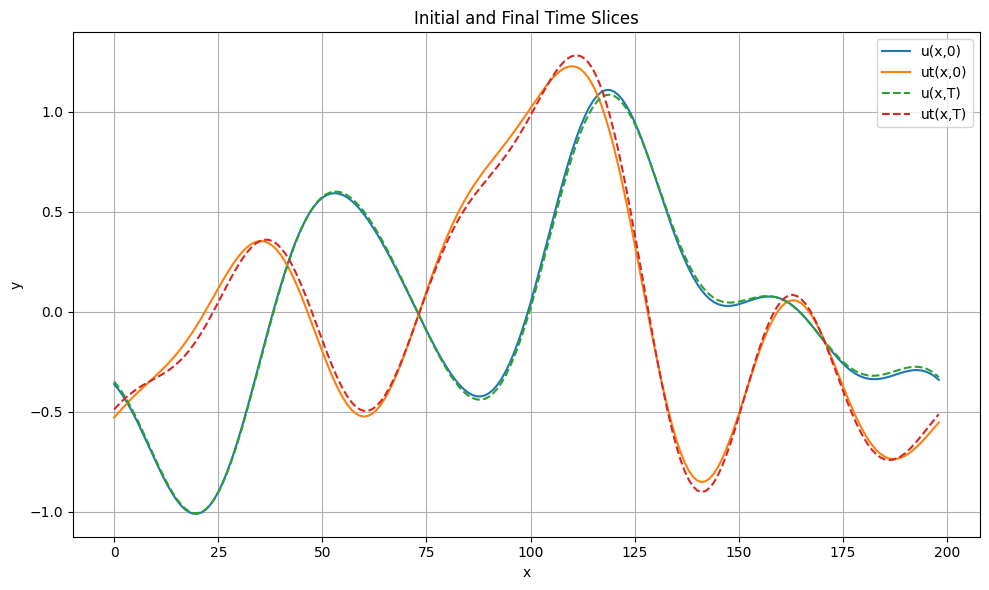

In [87]:
# Get the time-domain signal by inverse Fourier transform
y_physical = data[0].y

# Check periodicity by comparing first and last time points
first_timepoint = y_physical[..., 0]
last_timepoint = y_physical[..., -1]

# Calculate relative difference
rel_diff = torch.abs(first_timepoint - last_timepoint) / torch.abs(first_timepoint)
is_periodic = torch.allclose(first_timepoint, last_timepoint, rtol=1e-5)

print(f"Maximum relative difference between first and last timepoint: {rel_diff.max()}")
print(f"Is periodic: {is_periodic}")

# Plot both initial and final time slices on the same plot
plt.figure(figsize=(10, 6))
plt.plot(y_physical[0, 0, :, 0].detach().numpy(), label='u(x,0)', linestyle='solid')
plt.plot(y_physical[0, 1, :, 0].detach().numpy(), label='ut(x,0)', linestyle='solid')
plt.plot(y_physical[0, 0, :, -1].detach().numpy(), label='u(x,T)', linestyle='dashed')
plt.plot(y_physical[0, 1, :, -1].detach().numpy(), label='ut(x,T)', linestyle='dashed')
plt.title('Initial and Final Time Slices')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [88]:


def compute_energies_full_fourier(self, prelim_out, four_coef, og_x, og_y):
    if self.problem == '1d_wave':

        y = og_y[:,0,:,:]
        yt = og_y[:,1,:,:]

        wave_k = torch.fft.fftfreq(self.Nx, d=(self.Lx/self.Nx)) * 2 * np.pi  # Wave numbers

        u_hat = torch.fft.fft(y, dim=1)
        ut_hat = torch.fft.fft(yt, dim=1)

        og_target_energy_ut_component = torch.sum(torch.abs(ut_hat)**2, dim=1) * self.Lx / (self.Nx ** 2)
        og_target_energy_u_component = torch.sum(self.IC['c']**2 * (wave_k.unsqueeze(0).unsqueeze(-1).expand(u_hat.shape) ** 2) * torch.abs(u_hat)**2, dim=1) * self.Lx / (self.Nx ** 2)
        og_target_energy = og_target_energy_ut_component + og_target_energy_u_component

        u_hat = torch.fft.fftn(y, dim=(1,2))
        u = torch.fft.ifftn(u_hat, dim=(1,2))

        ux_hat = torch.fft.fft(u, dim=1)

        target_energy_ux_component = torch.sum(self.IC['c']**2 * (wave_k.unsqueeze(0).unsqueeze(-1).expand(ux_hat.shape) ** 2) * torch.abs(ux_hat)**2, dim=1) * self.Lx / (self.Nx ** 2)

        wave_kt = 2 * torch.pi * torch.fft.fftfreq(self.Nt, d=self.Lt / self.Nt)

        wave_kt_expanded = wave_kt.view(1, 1, -1)

        ut_hat = torch.fft.fft(y, dim=-1)

        dut_hat = wave_kt_expanded * ut_hat
        
        dut = torch.fft.ifft(dut_hat, dim=-1)

        fourc_coef_in_space = torch.fft.fft(dut, dim=1)

        target_energy_ut_component = torch.sum(torch.abs(fourc_coef_in_space) ** 2, dim=1) * self.Lx  / (self.Nx**2)

        target_energy = target_energy_ut_component + target_energy_ux_component

        
        if self.num_output_fn == 1:

            u = torch.fft.ifftn(four_coef, dim=(1,2))
            
            ux_hat = torch.fft.fft(u, dim=1)

            current_energy_ux_component = torch.sum(self.IC['c']**2 * (wave_k.unsqueeze(0).unsqueeze(-1).expand(ux_hat.shape) ** 2) * torch.abs(ux_hat)**2, dim=1) * self.Lx / (self.Nx ** 2)

            wave_kt = 2 * torch.pi * torch.fft.fftfreq(self.Nt, d=self.Lt / self.Nt)

            wave_kt_expanded = wave_kt.view(1, 1, -1)

            ut_hat = torch.fft.fft(u, dim=-1)

            dut_hat = wave_kt_expanded * ut_hat

            dut = torch.fft.ifft(dut_hat, dim=-1)

            fourc_coef_in_space = torch.fft.fft(dut, dim=1)

            current_energy_ut_component = torch.sum(torch.abs(fourc_coef_in_space) ** 2, dim=1) * self.Lx  / (self.Nx**2)

            current_energy = current_energy_ut_component + current_energy_ux_component

            learned_energy_ut_component = None
            learned_energy_ux_component = None
            learned_energy = None

            gt_u = og_x[:,0,:]
            gt_ut = og_x[:,1,:]

            gt_u_hat = torch.fft.fft(gt_u, n=self.Nx, dim=1)  # dim=1 since shape is (time, space)
            gt_ut_hat = torch.fft.fft(gt_ut, n=self.Nx, dim=1)

            true_energy_ut_component = torch.sum(torch.abs(gt_ut_hat)**2, dim=1) * self.Lx / (self.Nx ** 2)
            true_energy_ux_component = torch.sum(self.IC['c']**2 * (wave_k ** 2) * torch.abs(gt_u_hat)**2, dim=1) * self.Lx / (self.Nx ** 2)
            true_energy = true_energy_ut_component + true_energy_ux_component

        if self.num_output_fn == 2:
            raise NotImplementedError('Energy calculation for two output functions not implemented')
        
        energy_components = {'true_energy_u_component': true_energy_ux_component, 'true_energy_ut_component': true_energy_ut_component, 
                         'current_energy_u_component': current_energy_ux_component, 'current_energy_ut_component': current_energy_ut_component,
                         'learned_energy_u_component': learned_energy_ux_component, 'learned_energy_ut_component': learned_energy_ut_component,
                         'target_energy': target_energy, 'target_energy_ux_component': target_energy_ux_component, 'target_energy_ut_component': target_energy_ut_component,
                            'og_target_energy': og_target_energy, 'og_target_energy_ux_component': og_target_energy_u_component, 'og_target_energy_ut_component': og_target_energy_ut_component}

    return true_energy, current_energy, learned_energy, energy_components

def low_pass_filter_fft(data_fft, cutoff_ratio=0.8):
    """
    Zero out high frequency components beyond a certain ratio of the Nyquist frequency.
    """
    Nt = data_fft.shape[-1]
    cutoff = int(cutoff_ratio * (Nt // 2))
    filtered_fft = data_fft.clone()
    filtered_fft[..., cutoff:Nt - cutoff] = 0
    return filtered_fft


In [89]:
print(data[0].y.shape)

torch.Size([1, 2, 199, 399])


In [90]:
true_energy, current_energy, learned_energy, energy_components = compute_energies_full_fourier(my_args, None, torch.fft.ifftn(data[0].y, dim=(-2, -1)), data[0].x, data[0].y)

torch.Size([399])
torch.Size([1, 399])


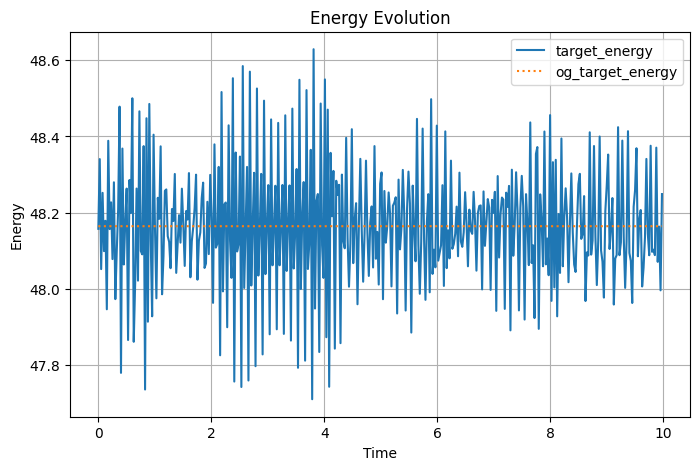

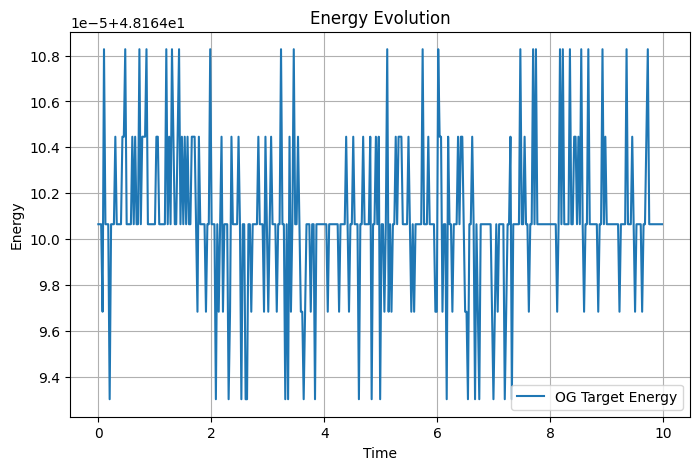

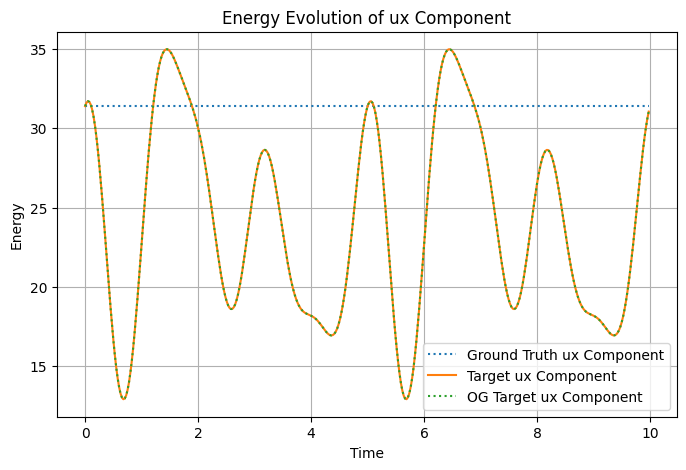

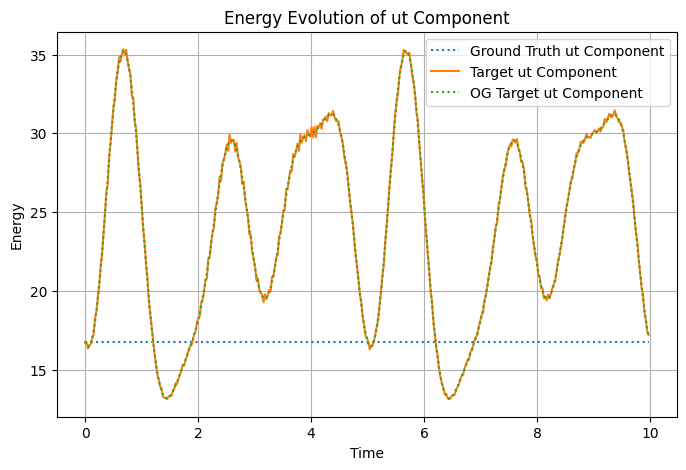

In [91]:
import matplotlib.pyplot as plt

example_t = torch.tensor(np.linspace(my_args.tmin, my_args.tmax, my_args.Nt, endpoint=False))

print(example_t.shape)
print(energy_components['target_energy'].shape)

# Plot energy over time
plt.figure(figsize=(8, 5))
# plt.plot(example_t.detach().cpu().numpy(), true_energy.T.detach().cpu().numpy(), label='Ground Truth')
plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy'].T.detach().cpu().numpy(), label='target_energy', linestyle='solid')
plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy'].T.detach().cpu().numpy(), label='og_target_energy', linestyle='dotted')
if learned_energy is not None:
    plt.plot(example_t.detach().cpu().numpy(), learned_energy.T.detach().cpu().numpy(), label='Learned Energy', linestyle='dotted')
# if current_energy is not None:
#     plt.plot(example_t.detach().cpu().numpy(), current_energy.T.detach().cpu().numpy(), label='Current Energy', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy'].T.detach().cpu().numpy(), label='OG Target Energy')
# plt.plot(example_t.detach().cpu().numpy(), true_energy.T.detach().cpu().numpy(), label='Ground Truth')
# if current_energy is not None:
#     plt.plot(example_t.detach().cpu().numpy(), current_energy.T.detach().cpu().numpy(), label='Current Energy', linestyle='dotted')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution')
plt.grid(True)
plt.legend()
plt.show()

#plot the ut components
plt.figure(figsize=(8, 5))
# plt.plot(example_t.detach().cpu().numpy(), energy.detach().cpu().numpy(), label='Energy')
# plt.plot(example_t.detach().cpu().numpy(), energy_learned_new.detach().cpu().numpy(), label='Energy')
plt.plot(example_t.detach().cpu().numpy(), energy_components['true_energy_u_component'].expand(example_t.shape).T.detach().cpu().numpy(), label='Ground Truth ux Component', linestyle='dotted')
plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ux_component'].T.detach().cpu().numpy(), label='Target ux Component', linestyle='solid')
plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy_ux_component'].T.detach().cpu().numpy(), label='OG Target ux Component', linestyle='dotted')

if learned_energy is not None:
    plt.plot(example_t.detach().cpu().numpy(), energy_components['learned_energy_u_component'].T.detach().cpu().numpy(), label='Learned Energy ux Component', linestyle='dotted')
# if current_energy is not None:
#     plt.plot(example_t.detach().cpu().numpy(), energy_components['current_energy_u_component'].T.detach().cpu().numpy(), label='Current Energy ux Component', linestyle='dotted')
# plt.plot(example_t.detach().cpu().numpy(), current_energy.detach().cpu().numpy(), label='Returned Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution of ux Component')
plt.grid(True)
plt.legend()
plt.show()


#plot the ut components
plt.figure(figsize=(8, 5))
# plt.plot(example_t.detach().cpu().numpy(), energy.detach().cpu().numpy(), label='Energy')
# plt.plot(example_t.detach().cpu().numpy(), energy_learned_new.detach().cpu().numpy(), label='Energy')
plt.plot(example_t.detach().cpu().numpy(), energy_components['true_energy_ut_component'].expand(example_t.shape).T.detach().cpu().numpy(), label='Ground Truth ut Component',linestyle='dotted')
plt.plot(example_t.detach().cpu().numpy(), energy_components['target_energy_ut_component'].T.detach().cpu().numpy(), label='Target ut Component', linestyle='solid')
plt.plot(example_t.detach().cpu().numpy(), energy_components['og_target_energy_ut_component'].T.detach().cpu().numpy(), label='OG Target ut Component', linestyle='dotted')
if learned_energy is not None:
    plt.plot(example_t.detach().cpu().numpy(), energy_components['learned_energy_ut_component'].T.detach().cpu().numpy(), label='Learned Energy ut Component', linestyle='dotted')
# if current_energy is not None:
#     plt.plot(example_t.detach().cpu().numpy(), energy_components['current_energy_ut_component'].T.detach().cpu().numpy(), label='Current Energy ut Component', linestyle='dotted')
# plt.plot(example_t.detach().cpu().numpy(), current_energy.detach().cpu().numpy(), label='Returned Energy')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.title('Energy Evolution of ut Component')
plt.grid(True)
plt.legend()
plt.show()

In [149]:
print(data[0].y.shape)

torch.Size([10, 2, 100, 50])


In [3]:
print(data[0].y.shape)

torch.Size([10, 2, 10, 100])


In [143]:
import torch

Nt_half = Nt // 2 + 1  # Only store non-negative frequencies in time

# Generate random independent components
real_part = torch.randn(Nx, Nt_half)
imag_part = torch.randn(Nx, Nt_half)  # No imaginary part for k_t = 0


def construct_full_fourier_matrix(Nx, Nt, F_half):
    """
    Construct a Hermitian-symmetric matrix efficiently without redundancy.
    
    Args:
        Nx (int): Number of spatial frequencies.
        Nt (int): Number of time frequencies.
    
    Returns:
        F_full (torch.Tensor): Full Hermitian-symmetric matrix of shape (Nx, Nt).
    """

    Nt_half = Nt // 2 + 1

    # Construct the independent part of the Fourier matrix
    # F_half = torch.complex(real_part, imag_part)

    if Nx % 2 == 0:
        F_half[Nx//2+1:,0] = torch.conj(torch.flip(F_half[1:Nx//2,0], dims=[0]))
        F_half[Nx//2,0] = F_half[Nx//2,0].real.clone()  # Nyquist row
        F_half[Nx//2+1:, -1] = torch.conj(torch.flip(F_half[1:Nx//2,-1], dims=[0]))
    else:
        print(F_half[Nx//2+1:,0].shape)
        print(F_half[:Nx//2+1 ,0].shape)
        print(torch.conj(torch.flip(F_half[1:Nx//2+1 ,0], dims=[0])).shape)
        F_half[Nx//2+1:,0] = torch.conj(torch.flip(F_half[1:Nx//2+1 ,0], dims=[0]))
        F_half[Nx//2+1:, -1] = torch.conj(torch.flip(F_half[1:Nx//2+1,-1], dims=[0]))
    
    if Nt % 2 == 0:
        F_half[0, -1] = F_half[0, -1].real.clone()  # Clone before modifying Nyquist column
        

    F_full = torch.empty(Nx, Nt, dtype=torch.complex64)

    # Copy non-negative frequencies
    F_full[:, :Nt_half] = F_half

    if Nt % 2 == 0:
        F_full[0,Nt//2+1:] = torch.conj(torch.flip(F_full[0,1:Nt//2], dims=[0]))
        F_full[1:,Nt//2+1:] = torch.conj(torch.flip(F_half[1:,1:-1],dims=[0,1]))
    else:
        F_full[0,Nt//2+1:] = torch.conj(torch.flip(F_full[0,1:Nt//2 + 1], dims=[0]))
        F_full[1:,Nt//2+1:] = torch.conj(torch.flip(F_half[1:,1:],dims=[0,1]))

    # Ensure real values at (0,0) and Nyquist frequency intersections
    F_full[0, 0] = F_full[0, 0].real.clone()  # DC component
    if Nx % 2 == 0 and Nt % 2 == 0:
        F_full[Nx//2, Nt//2] = F_full[Nx//2, Nt//2].real.clone()

    return F_full



In [121]:
#check if ifft output is real
def check_ifft_real(F_full):
    """
    Check if the inverse Fourier transform of a Hermitian-symmetric matrix is real.
    
    Args:
        F_full (torch.Tensor): Full Hermitian-symmetric matrix of shape (Nx, Nt).
    
    Returns:
        is_real (bool): True if the inverse Fourier transform is real, False otherwise.
    """
    # Compute the inverse Fourier transform
    f_full = torch.fft.ifftn(F_full, dim=(-2, -1))

    # Check if the real part is close to zero
    is_real = torch.allclose(f_full.imag, torch.zeros_like(f_full.real), atol=1e-5)
    
    return is_real

def check_recovery(F_full):
    """
    Check if the inverse Fourier transform of a Hermitian-symmetric matrix recovers the original matrix.
    
    Args:
        F_full (torch.Tensor): Full Hermitian-symmetric matrix of shape (Nx, Nt).
    
    Returns:
        is_recovered (bool): True if the inverse Fourier transform recovers the original matrix, False otherwise.
    """
    # Compute the inverse Fourier transform
    f_full = torch.fft.ifftn(F_full, dim=(-2, -1))

    # Compute the forward Fourier transform
    F_full_recovered = torch.fft.fftn(f_full, dim=(-2, -1))

    # Check if the recovered matrix is close to the original matrix
    is_recovered = torch.allclose(F_full, F_full_recovered, atol=1e-5)
    
    return is_recovered

In [122]:
# Example for a 6x6 matrix
for Nx in range(2, 7):
    for Nt in range(2, 7):
        F_full = construct_hermitian_matrix(Nx, Nt)
        is_real = check_ifft_real(F_full)
        is_recovered = check_recovery(F_full)
        print(f"Nx = {Nx}, Nt = {Nt}, is_real = {is_real}, is_recovered = {is_recovered}")


Nx = 2, Nt = 2, is_real = True, is_recovered = True
Nx = 2, Nt = 3, is_real = True, is_recovered = True
Nx = 2, Nt = 4, is_real = True, is_recovered = True
Nx = 2, Nt = 5, is_real = True, is_recovered = True
Nx = 2, Nt = 6, is_real = True, is_recovered = True
Nx = 3, Nt = 2, is_real = True, is_recovered = True
Nx = 3, Nt = 3, is_real = True, is_recovered = True
Nx = 3, Nt = 4, is_real = True, is_recovered = True
Nx = 3, Nt = 5, is_real = True, is_recovered = True
Nx = 3, Nt = 6, is_real = True, is_recovered = True
Nx = 4, Nt = 2, is_real = True, is_recovered = True
Nx = 4, Nt = 3, is_real = True, is_recovered = True
Nx = 4, Nt = 4, is_real = True, is_recovered = True
Nx = 4, Nt = 5, is_real = True, is_recovered = True
Nx = 4, Nt = 6, is_real = True, is_recovered = True
Nx = 5, Nt = 2, is_real = True, is_recovered = True
Nx = 5, Nt = 3, is_real = True, is_recovered = True
Nx = 5, Nt = 4, is_real = True, is_recovered = True
Nx = 5, Nt = 5, is_real = True, is_recovered = True
Nx = 5, Nt =

In [130]:
#generate random f_full of dim Nx, Nt
f_full = torch.randn(10,5)
F_full = torch.fft.fftn(f_full, dim=(-2, -1))

print(F_full.real)
print(F_full.imag)

tensor([[12.5039,  0.1178,  4.8728,  4.8728,  0.1178],
        [ 0.4384,  6.5763, -7.8406,  1.7181,  3.8307],
        [-1.1356, -2.7943,  5.3607, -1.7178, -3.6015],
        [-1.9592, -1.4845, -3.3788,  0.1182, -2.5546],
        [-2.3991, -2.6235, -2.0845,  2.3827,  1.6553],
        [-0.1492, -5.0440, -4.4567, -4.4567, -5.0440],
        [-2.3991,  1.6553,  2.3827, -2.0845, -2.6235],
        [-1.9592, -2.5546,  0.1182, -3.3788, -1.4845],
        [-1.1356, -3.6015, -1.7178,  5.3607, -2.7943],
        [ 0.4384,  3.8307,  1.7181, -7.8406,  6.5763]])
tensor([[ 0.0000e+00, -2.3441e+00, -4.8746e+00,  4.8746e+00,  2.3441e+00],
        [-2.6138e+00,  3.4373e+00, -7.0766e+00, -2.3131e+00, -8.0804e+00],
        [ 7.6066e+00, -7.2972e-01, -2.7882e+00,  9.6095e+00, -7.8719e-01],
        [-4.1042e+00,  1.1716e+01, -2.8724e+00,  1.3791e+00, -2.7648e+00],
        [ 5.3833e-01,  8.0472e+00,  7.5901e+00, -4.6846e+00, -2.9956e+00],
        [ 6.7055e-08, -3.2828e-01,  5.6807e+00, -5.6807e+00,  3.2828e-01],

In [160]:
Nt_half = Nt // 2 + 1  # Only store non-negative frequencies in time

# Generate random independent components
real_part = torch.randn(Nx, Nt_half)
imag_part = torch.randn(Nx, Nt_half)  # No imaginary part for k_t = 0

F_half = torch.complex(real_part, imag_part)

F_full = construct_full_fourier_matrix(Nx, Nt, F_half)

F_full.shape

torch.Size([99])
torch.Size([100])
torch.Size([99])


torch.Size([199, 49])

In [161]:
print(check_ifft_real(F_full))

print(check_recovery(F_full))

print(torch.fft.rfft2(f_full).shape)

True
True
torch.Size([10, 3])


In [126]:
scaling_factor = 

2

In [44]:
f_full = torch.fft.ifftn(F_full, dim=(0, 1), norm='ortho')
F_recovered = torch.fft.fftn(f_full, dim=(0, 1), norm='ortho')


In [47]:
print(F_full)
print(F_recovered)

tensor([[-0.2858+0.0000j,  1.1945-0.5649j,  1.1945+0.5649j],
        [ 0.3442-0.1746j, -1.3853-0.1388j, -0.1205-0.7696j],
        [ 0.3442+0.1746j, -0.1205+0.7696j, -1.3853+0.1388j]])
tensor([[-0.2858+0.0000j,  1.1945-0.5649j,  1.1945+0.5649j],
        [ 0.3442-0.1746j, -1.3853-0.1388j, -0.1205-0.7696j],
        [ 0.3442+0.1746j, -0.1205+0.7696j, -1.3853+0.1388j]])


In [158]:
k = torch.fft.fftfreq(3, d=(1/3)) * 2 * torch.pi  # Wave numbers


In [159]:
k = k.unsqueeze(0).unsqueeze(-1).expand((10,3,5))

print(k[0,:,0])

tensor([ 0.0000,  6.2832, -6.2832])
